In [1]:
import os

import torch
import numpy as np
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader

from neulight.dataset.free_viewpoint import FreeViewpointDataset
from neulight.model.neureflect import NeuReflectLightningModel
from neulight.utils.files import read_file
from neulight.visualization.visualize_rays import visualize_rays

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Read Config

In [2]:
config = read_file("../config/neureflect.yaml")

## Sample a batch of rays from the training dataset

In [3]:
dtype = torch.float32
device = torch.cuda.current_device()
batch_size = 4
num_workers = 2
free_viewpoint_scene_path = "../data/neulight/Salon2"
num_rays_per_image = 1024

In [4]:
free_viewpoint_train_dataset = FreeViewpointDataset(
    scene_path=free_viewpoint_scene_path,
    dataset_type="train",
    num_rays_per_image=num_rays_per_image,
)
free_viewpoint_train_dataloader = DataLoader(
    free_viewpoint_train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=free_viewpoint_train_dataset.collate_fn,
    num_workers=num_workers,
    persistent_workers=True,
)

In [5]:
batch = free_viewpoint_train_dataset.move_batch_to(
    next(iter(free_viewpoint_train_dataloader)),
    device=device,
    dtype=dtype,
)

In [6]:
image = visualize_rays(
    batch["inputs"]["rays"],
    batch["labels"]["colors"],
    interactive=False,
)

FEngine (64 bits) created at 0x55a7bfd31e80 (threading is enabled)
EGL(1.5)
OpenGL(4.1)


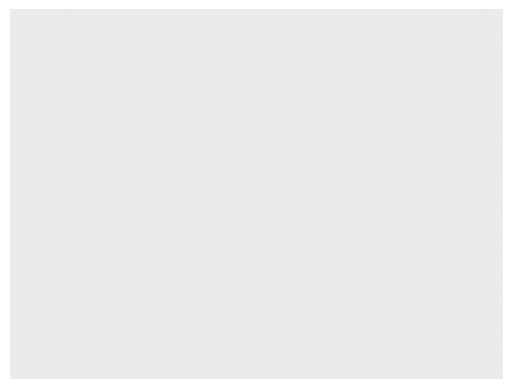

In [7]:
plt.imshow(image)
plt.axis("off")
plt.show()

## Initialize the model

In [19]:
neureflect_model = NeuReflectLightningModel(config["model"]).to(device)

In [20]:
colors, hit_masks = neureflect_model(batch["inputs"]["rays"])

In [21]:
loss = neureflect_model.loss(colors, batch["labels"]["colors"], hit_masks)

In [22]:
loss

tensor(0.1264, device='cuda:0', grad_fn=<MseLossBackward0>)

In [23]:
loss.backward()